<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Adversarial_FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#A Tutorial of Advisorial Attacks:  Fast Gradient Sign Method (FGSM)

The reference 1 is a great tutorial, but I fixed some codes issues. All credits belong to Drs. Zico Kolter and Aleksander Madry.

Reference 
[1] https://adversarial-ml-tutorial.org/adversarial_examples/



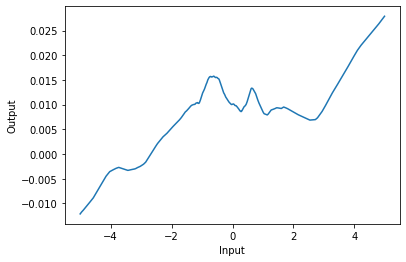

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(21500):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-5,5,0.01), model(torch.arange(-5,5,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [5]:
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.134350	0.516852	0.080600	0.288659
0.076133	0.266996	0.062800	0.223710
0.059867	0.212376	0.054300	0.186508
0.049100	0.175558	0.047000	0.160993
0.042350	0.148989	0.042300	0.140339
0.036300	0.129571	0.037000	0.126097
0.032300	0.113915	0.035300	0.119150
0.028600	0.101957	0.030600	0.105701
0.026400	0.092425	0.028400	0.100113
0.023317	0.083813	0.027000	0.092275


In [6]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

#model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
#model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
#model_cnn.load_state_dict(torch.load("model_cnn.pt"))

In [7]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [8]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

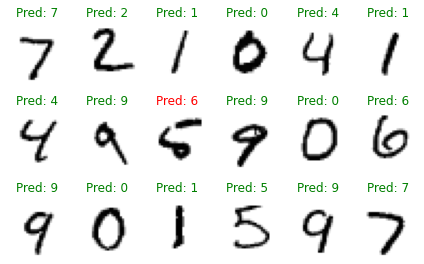

In [9]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

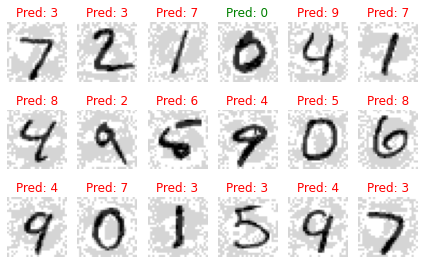

In [10]:
### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

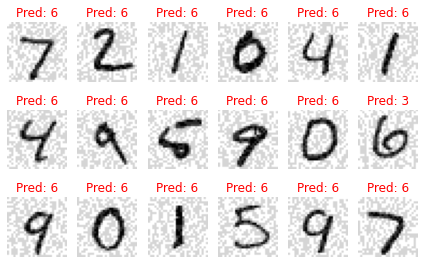

In [11]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [13]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9301
4-layer DNN: 0.9948
        CNN: 0.9981


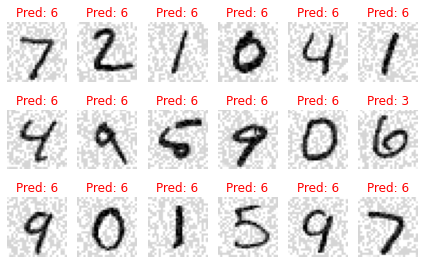

In [15]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [16]:
delta = torch.zeros_like(X, requires_grad=True)
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()
print(delta.grad.abs().mean().item())

1.6854711475389195e-06


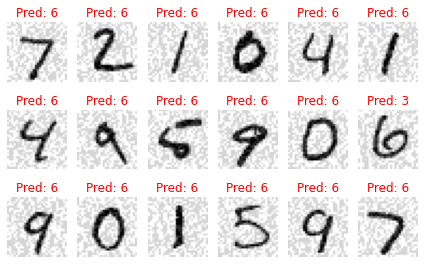

In [17]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [18]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9646
4-layer DNN: 1.0
CNN: 0.9998


In [19]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 0.9998


In [30]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


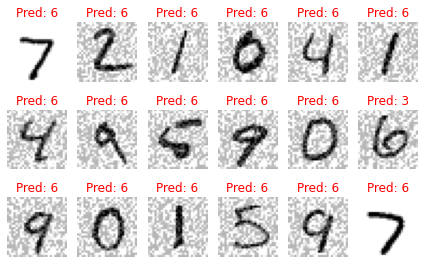

In [31]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=7)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

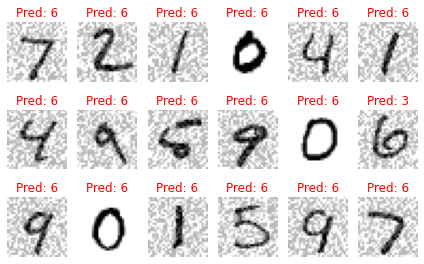

In [32]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)